In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cmdstanpy import CmdStanModel
import pandas as pd
import json
import pickle
import os

# Load data

## Behavioural data


In [15]:

df_raw = pd.read_csv('data/pilot/raw/20_01_2025/tom_dictator_v2_2025-01-20.csv')
                     
# Replace full stop with underscore in df_raw column names
df_raw.columns = df_raw.columns.str.replace('.', '_')

sessions = [
    'tgvqauld',
    'ta176utg'
]

# Only keep rows where session_id is in sessions and where participant_label is not NaN
df_full = df_raw[df_raw['session_code'].isin(sessions) & df_raw['participant_label'].notna() & (df_raw['participant__current_page_name'] == 'End')]
# Insert 
columns = ['participant_code', 'participant_label', 'session_code',
       
       'player_block_type', 'player_block_idx', 'player_idx_in_block', 'player_trust_cond', 'player_trust_label',
       'player_intention', 'player_interest', 
       'player_certainty', 'player_certainty_val', 'player_rigidity', 'player_rigidity_val',
       'player_k_lvl', 'player_trust_predicted', 'player_alpha_prior',
       'player_alpha_prior_entropy', 'player_alpha', 'player_alpha_entropy',
       'player_beta_prior', 'player_beta_prior_entropy', 'player_beta',
       'player_beta_entropy', 'player_beta_social_prior',
       'player_beta_social_prior_entropy', 'player_beta_social',
       'player_beta_social_entropy', 'player_path_taken',
       'player_perceived_certainty_certain',
       'player_perceived_certainty_uncertain',
       'player_perceived_certainty_immutable', 'player_attention',
       'player_attention_passed', 'player_attention_correct',

       'player_focus_work_high', 'player_focus_work_medium', 'player_focus_work_low',
       'player_strategy_high', 'player_strategy_low', 'player_strategy_medium',

       'subsession_round_number',
       'participant__current_app_name',
       'participant__current_page_name', 
       'player_payoff',
]


df = df_full[columns]

# If player is in column name, remove player_ from column name
df.columns = df.columns.str.replace('player_', '')


df_long = df[(df.block_type == 'test') & (df.trust_cond != 'none')][['participant_code', 'intention', 'certainty', 'rigidity', 'intention', 'trust_cond', 'trust_label', 'path_taken']]

# Get dummies for path taken and concat with df_long
path_taken_dummies = pd.get_dummies(df_long['path_taken'], prefix='', prefix_sep='')
df_long = pd.concat([df_long, path_taken_dummies], axis=1)

df_long['delivered'] = df_long['A'] + df_long['B'] > 0
df_long['path_hidden'] = df_long['B'] + df_long['C'] > 0

# Create path_idx column
path_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
}
df['path_idx'] = df['path_taken'].map(lambda x: path_dict[x])
df_long['path_idx'] = df_long['path_taken'].map(lambda x: path_dict[x])

# Create certainty_lvl column
certainties_dict = {
    'uncertain': 1,
    'certain': 2,
    'immutable': 3,
}
df_long['certainty_lvl'] = df_long['certainty'].map(lambda x: certainties_dict[x])
df['certainty_lvl'] = df['certainty'].map(lambda x: certainties_dict[x])

# Create trust_lvl column
trusts_dict = {
    'none': 4,
    'very_low': 0.5,
    'low': 1,
    'slightly_low': 1.5,
    'medium': 2,
    'slightly_high': 2.5,
    'high': 3,
    'very_high': 3.5,
}
df_long['trust_lvl'] = df_long['trust_label'].map(lambda x: trusts_dict[x])
df_long['trust_cond_lvl'] = df_long['trust_cond'].map(lambda x: trusts_dict[x])
df['trust_lvl'] = df['trust_label'].map(lambda x: trusts_dict[x])
df['trust_cond_lvl'] = df['trust_cond'].map(lambda x: trusts_dict[x])


# Assign unique integer to each participant and make sure it is the same for both df and df_long and recoverable
df_long['part_idx'] = pd.Categorical(df_long['participant_code']).codes
df['part_idx'] = pd.Categorical(df['participant_code']).codes


paths_colors = {
    'A': np.array([238, 154, 86])/255,
    'B': np.array([183, 117, 63])/255,
    'C': np.array([50, 114, 169])/255,
    'D': np.array([88, 182, 225])/255,
}

/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_44417/1701408934.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['path_idx'] = df['path_taken'].map(lambda x: path_dict[x])
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_44417/1701408934.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['certainty_lvl'] = df['certainty'].map(lambda x: certainties_dict[x])
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_44417/1701408934.py:87: SettingWithCopyWarning: 
A value is 

In [16]:
# Pivot df_wide on block_idx after keeping only path_idx as a column
stan_data = dict()

# Get only test blocks and keep only part_idx, certainty_lvl, trust_lvl, path_idx and block_idx
df_wide = df[df.block_type == 'test'][['part_idx', 'certainty_lvl', 'trust_lvl', 'trust_cond_lvl', 'path_idx', 'block_idx']].dropna()

# Pivot df_wide on block_idx for path_idx
df_path_idx = df_wide[['part_idx', 'path_idx', 'block_idx']].dropna()
df_path_idx = df_path_idx.pivot(index='part_idx', columns='block_idx', values='path_idx')
stan_data['y'] = df_path_idx.to_numpy().tolist()

# Pivot df_wide on block_idx for certainty_lvl
df_certainty = df_wide[['part_idx', 'certainty_lvl', 'block_idx']].dropna()
df_certainty = df_certainty.pivot(index='part_idx', columns='block_idx', values='certainty_lvl')
stan_data['certainties'] = df_certainty.to_numpy().tolist()

# Pivot df_wide on block_idx for trust_lvl
df_trust = df_wide[['part_idx', 'trust_cond_lvl', 'block_idx']].dropna()
df_trust = df_trust.pivot(index='part_idx', columns='block_idx', values='trust_cond_lvl')
stan_data['trusts'] = df_trust.to_numpy().astype(int).tolist()

# Meta data
stan_data['M'], stan_data['N'] = df_path_idx.shape
stan_data['A'] = df_path_idx.nunique().max()
stan_data['C'] = df_certainty.nunique().max()
stan_data['T'] = df_trust.nunique().max()

# Stan data to json
json.dump(stan_data, open('stan_files/tom_model_basic_data.json', 'w'))

In [17]:
stan_data_heuristic = dict()

df_wide = df[df.block_type == 'explore'][['part_idx', 'certainty_lvl', 'trust_lvl', 'trust_cond_lvl', 'path_idx', 'block_idx', 'idx_in_block']].dropna()

# Pivot df_wide on block_idx after keeping only path_idx as a column
df_path_idx = df_wide[['part_idx', 'path_idx', 'block_idx', 'idx_in_block']].dropna()
df_path_idx = df_path_idx.pivot(index='part_idx', columns=['block_idx', 'idx_in_block'], values='path_idx')
df_path_idx = df_path_idx.unstack(level=0)
df_path_idx = df_path_idx.to_xarray().transpose('part_idx', 'block_idx', 'idx_in_block')
stan_data_heuristic['y'] = df_path_idx.to_numpy().tolist()

# Pivot df_wide on block_idx for certainty_lvl
df_certainty = df_wide[['part_idx', 'certainty_lvl', 'block_idx', 'idx_in_block']].dropna()
df_certainty = df_certainty.pivot(index='part_idx', columns=['block_idx', 'idx_in_block'], values='certainty_lvl')
df_certainty = df_certainty.unstack(level=0)
df_certainty = df_certainty.to_xarray().transpose('part_idx', 'block_idx', 'idx_in_block')
stan_data_heuristic['certainties'] = df_certainty.to_numpy().tolist()

# Pivot df_wide on block_idx for trust_lvl
df_trust = df_wide[['part_idx', 'trust_lvl', 'block_idx', 'idx_in_block']].dropna()
df_trust = df_trust.pivot(index='part_idx', columns=['block_idx', 'idx_in_block'], values='trust_lvl')
df_trust = df_trust.unstack(level=0)
df_trust = df_trust.to_xarray().transpose('part_idx', 'block_idx', 'idx_in_block')
stan_data_heuristic['trusts'] = df_trust.to_numpy().tolist()

# Meta data
stan_data_heuristic['M'], stan_data_heuristic['N'], stan_data_heuristic['K'] = df_path_idx.shape
stan_data_heuristic['A'] = np.unique(df_path_idx.to_numpy().flatten()).size
stan_data_heuristic['C'] = np.unique(df_certainty.to_numpy().flatten()).size
stan_data_heuristic['T'] = np.unique(df_trust.to_numpy().flatten()).size

# Test data
df_test = df[df.block_type == 'test'][['part_idx', 'certainty_lvl', 'trust_cond_lvl', 'path_idx', 'block_idx', 'idx_in_block']].dropna()
# Pivot df_test on block_idx after keeping only path_idx as a column
df_test_path_idx = df_test[['part_idx', 'path_idx', 'block_idx']].dropna()
df_test_path_idx = df_test_path_idx.pivot(index='part_idx', columns='block_idx', values='path_idx')
stan_data_heuristic['y_test'] = df_test_path_idx.to_numpy().tolist()
# Pivot df_test on block_idx for certainty_lvl
df_test_certainty = df_test[['part_idx', 'certainty_lvl', 'block_idx']].dropna()
df_test_certainty = df_test_certainty.pivot(index='part_idx', columns='block_idx', values='certainty_lvl')
stan_data_heuristic['certainties_test'] = df_test_certainty.to_numpy().tolist()
# Pivot df_test on block_idx for trust_lvl
df_test_trust = df_test[['part_idx', 'trust_cond_lvl', 'block_idx']].dropna()
df_test_trust = df_test_trust.pivot(index='part_idx', columns='block_idx', values='trust_cond_lvl')
stan_data_heuristic['trusts_test'] = df_test_trust.to_numpy().astype(int).tolist()

# Meta data
_, stan_data_heuristic['N_test'] = df_test_path_idx.shape

# Stan data to json
json.dump(stan_data_heuristic, open('stan_files/heuristic_model_data.json', 'w'))

In [18]:
df_path_idx

<xarray.DataArray (part_idx: 99, block_idx: 11, idx_in_block: 5)>
array([[[2, 1, 3, 2, 4],
        [1, 2, 3, 3, 2],
        [4, 1, 2, 2, 3],
        ...,
        [1, 1, 3, 1, 4],
        [3, 3, 1, 2, 4],
        [1, 1, 1, 1, 4]],

       [[2, 1, 2, 3, 3],
        [4, 4, 4, 4, 4],
        [1, 3, 3, 3, 3],
        ...,
        [3, 3, 3, 3, 4],
        [1, 4, 4, 4, 4],
        [4, 4, 4, 4, 4]],

       [[2, 3, 2, 2, 3],
        [1, 2, 2, 1, 2],
        [2, 3, 2, 2, 3],
        ...,
...
        ...,
        [4, 4, 4, 1, 4],
        [3, 4, 4, 3, 4],
        [3, 3, 3, 4, 3]],

       [[2, 2, 2, 3, 4],
        [2, 2, 2, 3, 4],
        [2, 2, 2, 3, 4],
        ...,
        [2, 2, 2, 3, 4],
        [2, 2, 2, 3, 4],
        [2, 2, 2, 2, 3]],

       [[3, 1, 2, 3, 4],
        [1, 3, 4, 1, 4],
        [1, 4, 4, 1, 2],
        ...,
        [1, 1, 1, 1, 4],
        [1, 1, 1, 1, 4],
        [1, 1, 1, 4, 1]]])
Coordinates:
  * block_idx     (block_idx) int64 0 1 2 3 4 5 6 7 8 9 10
  * idx_in_block  (idx_in_block) int64 0 1 2 3 4
  * part_idx      (part_idx) int8 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98

## Model data

In [19]:
variants = [
    'heuristic_test',
    #'basic_fulltemp',
    #'basic_full',
    #'onlyalpha',
    #'nobeta'
    #'nodelta',
    #'fullexp',
    #'nobetaexp',
    #'nodeltaexp'   
]
variant = variants[0]

# Load Stan model
with open(f'stan_files/tom_model_{variant}_model.pkl', 'rb') as f:
    model = pickle.load(f)
    
# Load Stan fit object
with open(f'stan_files/tom_model_{variant}_fit.pkl', 'rb') as f:
    fit = pickle.load(f)

if 'heuristic' in variant:
    data_file = os.path.join('.', 'stan_files', 'heuristic_model_data.json')
else:
    data_file = os.path.join('.', 'stan_files', 'tom_model_basic_data.json')


# Inspect the results

In [20]:
df_summary = fit.summary()
quantities = model.generate_quantities(data=data_file, previous_fit=fit)
draws = quantities.draws_pd()
df_summary.head(20)

16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [2] start processing
16:22:05 - cmdstanpy - INFO - Chain [3] start processing
16:22:05 - cmdstanpy - INFO - Chain [4] start processing
16:22:06 - cmdstanpy - INFO - Chain [2] done processing
16:22:06 - cmdstanpy - INFO - Chain [1] done processing
16:22:06 - cmdstanpy - INFO - Chain [3] done processing
16:22:06 - cmdstanpy - INFO - Chain [4] done processing
16:22:06 - cmdstanpy - WARNING - Sample doesn't contain draws from warmup iterations, rerun sampler with "save_warmup=True".


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-7669.310000,0.699023,21.569500,-7704.690000,-7669.230000,-7634.500000,952.130000,12.649700,1.002200
certainty_w[1],0.021877,0.011349,0.987153,-1.602160,0.004367,1.625190,7565.610000,100.514000,0.999444
certainty_w[2],-0.003453,0.011291,0.988615,-1.622820,0.003572,1.644340,7666.580000,101.856000,0.999672
certainty_w[3],-0.006331,0.012450,1.026360,-1.680930,0.009580,1.641070,6795.730000,90.285900,0.999533
sigma_certainty_w,1.038314,0.014208,1.075441,0.045692,0.712021,3.161440,5729.700309,76.122976,0.999538
trust_w,-0.005684,0.011840,1.001783,-1.708270,-0.007112,1.664980,7158.272686,95.102535,1.000049
sigma_trust_w,1.027936,0.013075,1.026360,0.046313,0.728644,3.127090,6162.306601,81.870446,0.999660
certainty_trust_w[1],-0.031635,0.011445,1.009550,-1.670420,-0.034471,1.619050,7780.940000,103.375000,0.999577
certainty_trust_w[2],0.014468,0.010652,0.964665,-1.565050,0.017206,1.586790,8201.030000,108.956000,0.999469
certainty_trust_w[3],-0.004473,0.010693,0.976566,-1.607590,-0.007828,1.578150,8341.050000,110.817000,0.999854


## Process and store the results

### Parameter estimates

In [21]:
draws.columns[600]

'certainty_trust_w_M_sim[7,2]'

In [22]:
# Only columns which are not y_sim
draws_params = draws[[col for col in draws.columns if 'y_sim' not in col]]
# Get number of participants
M = stan_data['M']

# Create list of participant data
part_data = []

# Iterate over the columns of draws_params

for col in draws_params.columns[:]:
    # Get the values of M and N from the column name
    mc = col.split('[')[1][:-1]
    if len(mc.split(',')) == 1:
        m = int(mc)
        c = None

        if 'heuristic' in variant:
            weight = 1
            # For heuristic models
            if 'boss_w_M_sim' in col:
                param_code = 0
                trial_code = 0
            elif 'trust_w_M_sim' in col:
                param_code = 2
                trial_code = 0
            
        else:
            weight = 1
            trial_code = 0

            # For ToM models
            if 'alpha_M_sim' in col:
                param_code = 0
            elif 'beta_M_sim' in col:
                param_code = 1
            elif 'delta_M_sim' in col:
                param_code = 2

        
    else:
        m, c = mc.split(',')
        m = int(m)
        c = int(c)

        if 'heuristic' in variant:
            weight = 1

            if 'certainty_trust' in col:
                param_code = 3
                trial_code = c
            elif 'certainty' in col:
                param_code = 1
                trial_code = c
            elif 'trust' in col:
                param_code = 2
                trial_code = c

            

        else:
            weight = 0
            trial_code = 0

            if c == 1:
                param_code = 1
            elif c == 2:
                param_code = 2
            elif c == 3:
                param_code = 3

    # Get the values of y_sim
    param_sims = draws_params[col].values

    # Create a new np array with the values of part_idx, block_idx and y_sim
    part_array = np.array([
        np.arange(param_sims.size), # Sim index
        m*np.ones(param_sims.size), # Participant index
        weight*np.ones(param_sims.size), # Weight or inverse temperature
        param_code*np.ones(param_sims.size), # Parameter code   
        trial_code*np.ones(param_sims.size), # Trial code 
        param_sims]).T
    
    # Append to part_data
    part_data.append(part_array)

part_data_arr = np.concatenate(part_data)

In [23]:
# Add to df_params with columns named part_idx, weight, param_code, value
df_params = pd.DataFrame(part_data_arr, columns=['sim_idx', 'part_idx', 'weight', 'param_code', 'trial_code', 'value'])
# Convert part_idx to int, weight to bool and param_code to int
df_params['sim_idx'] = df_params['sim_idx'].astype(int)
df_params['part_idx'] = df_params['part_idx'].astype(int) - 1
df_params['weight'] = df_params['weight'].astype(bool)
df_params['param_code'] = df_params['param_code'].astype(int)
df_params['trial_code'] = df_params['trial_code'].astype(int)

# Rename param_code to param_name. 
# If weight == True then 0: alpha, 1: beta, 2: delta
# if weight == False then use certainty_dict
if 'heuristic' in variant:
    param_dict = {
        0: 'boss',
        1: 'certainty',
        2: 'trust',
        3: 'certainty_trust',
    }
    certainty_dict = {
        1: 'uncertain',
        2: 'certain',
        3: 'immutable',
    }
    trust_dict = {
        4: 'none',
        1: 'low',
        2: 'medium',
        3: 'high',  
    }
    
    def gen_param_name(row):
        if row['param_code'] == 0:
            return param_dict[row['param_code']]
        elif row['param_code'] == 1:
            return param_dict[row['param_code']] + '_' + certainty_dict[row['trial_code']]
        elif row['param_code'] == 2:
            return param_dict[row['param_code']]
        elif row['param_code'] == 3:
            return param_dict[row['param_code']] + '_' + certainty_dict[row['trial_code']]
    df_params['param_name'] = df_params.apply(lambda x: gen_param_name(x), axis=1)
else:
    param_dict = {
        0: 'alpha',
        1: 'beta',
        2: 'delta',
    }
    inv_temp_dict = {
        1: 'prior_inv_temp_uncertain',
        2: 'prior_inv_temp_certain',
        3: 'prior_inv_temp_immutable',
    }
    df_params['param_name'] = df_params.apply(lambda x: param_dict[x['param_code']] if x['weight'] else inv_temp_dict[x['param_code']], axis=1)

# Recover participant code from pd.Categorical(df['participant_code']).codes
df_params['participant_code'] = pd.Categorical(df['participant_code']).categories[df_params['part_idx']]

# Move value to the end
df_params = df_params[['sim_idx', 'part_idx', 'participant_code', 'weight', 'param_code', 'trial_code', 'param_name', 'value']]

# Save to csv
df_params.to_csv(f'stan_files/tom_model_{variant}_params.csv', index=False)


In [24]:
df_params['param_code'].unique()

array([0, 1, 2, 3])

### Simulated data

Structure: wide

Desired: long
Columns: 
- sim_idx
- part_idx
- block_idx
- certainty_lvl
- trust_lvl
- path_idx

In [25]:
# Create list of participant data
part_data = []

# First drop all columns that are not y_sim
draws_y = draws.filter(like='y_sim')
# Get the number of indices of M and N
M = stan_data['M']
N = stan_data['N']
# Iterate over the columns of draws_y

for col in draws_y.columns[:]:
    # Get the values of M and N from the column name
    mn = col.split('[')[1][:-1]
    m, n = mn.split(',')
    m = int(m)
    n = int(n)
    # Get the values of y_sim
    y_sim = draws_y[col].values

    
    # Create a new np array with the values of part_idx, block_idx and y_sim
    part_array = np.array([
        np.arange(y_sim.size),
        m*np.ones(y_sim.size), 
        n*np.ones(y_sim.size), 
        y_sim
    ]).T
    
    # Append to part_data
    part_data.append(part_array)

# Concatenate part_data
part_data_arr = np.concatenate(part_data)

In [26]:

# Add to draws_long
df_Ys = pd.DataFrame(part_data_arr.astype(int), columns=['sim_idx', 'part_idx', 'block_idx_local', 'y_sim'])

# Add certainty and trust to df_Ys_l
# Get the certainty and trust values for each block_idx
certainties = np.array(stan_data['certainties'])
trusts = np.array(stan_data['trusts'])

# Create new columns in df_Ys_l using the part_idx and block_idx columns as indices for certainties and trusts
df_Ys['certainty_lvl'] = certainties[df_Ys['part_idx'].values-1, df_Ys['block_idx_local'].values-1]
df_Ys['trust_lvl'] = trusts[df_Ys['part_idx'].values-1, df_Ys['block_idx_local'].values-1]

# Rename y_sim to path_idx_sim
df_Ys.columns = ['sim_idx', 'part_idx', 'block_idx_local', 'path_idx_sim', 'certainty_lvl', 'trust_lvl']

# Remap path_idx_sim to path_taken_sim using path_dict, same for certainty_lvl and trust_lvl
df_Ys['path_taken_sim'] = df_Ys['path_idx_sim'].map(lambda x: list(path_dict.keys())[list(path_dict.values()).index(x)])
df_Ys['certainty'] = df_Ys['certainty_lvl'].map(lambda x: list(certainties_dict.keys())[list(certainties_dict.values()).index(x)])
df_Ys['trust'] = df_Ys['trust_lvl'].map(lambda x: list(trusts_dict.keys())[list(trusts_dict.values()).index(x)])

df_Ys['part_idx'] = df_Ys['part_idx'] - 1
df_Ys['block_idx_local'] = df_Ys['block_idx_local'] - 1

# Recover participant code from pd.Categorical(df['participant_code']).codes
df_Ys['participant_code'] = pd.Categorical(df['participant_code']).categories[df_Ys['part_idx']-1]

df_Ys['block_idx'] = df_Ys['block_idx_local'] + 10

df_Ys = df_Ys[['sim_idx', 'part_idx', 'participant_code', 'block_idx_local', 'block_idx', 'certainty_lvl', 'trust_lvl', 'certainty', 'trust', 'path_idx_sim', 'path_taken_sim']]

# Save to csv
df_Ys.to_csv(f'stan_files/tom_model_{variant}_y_sim.csv', index=False)

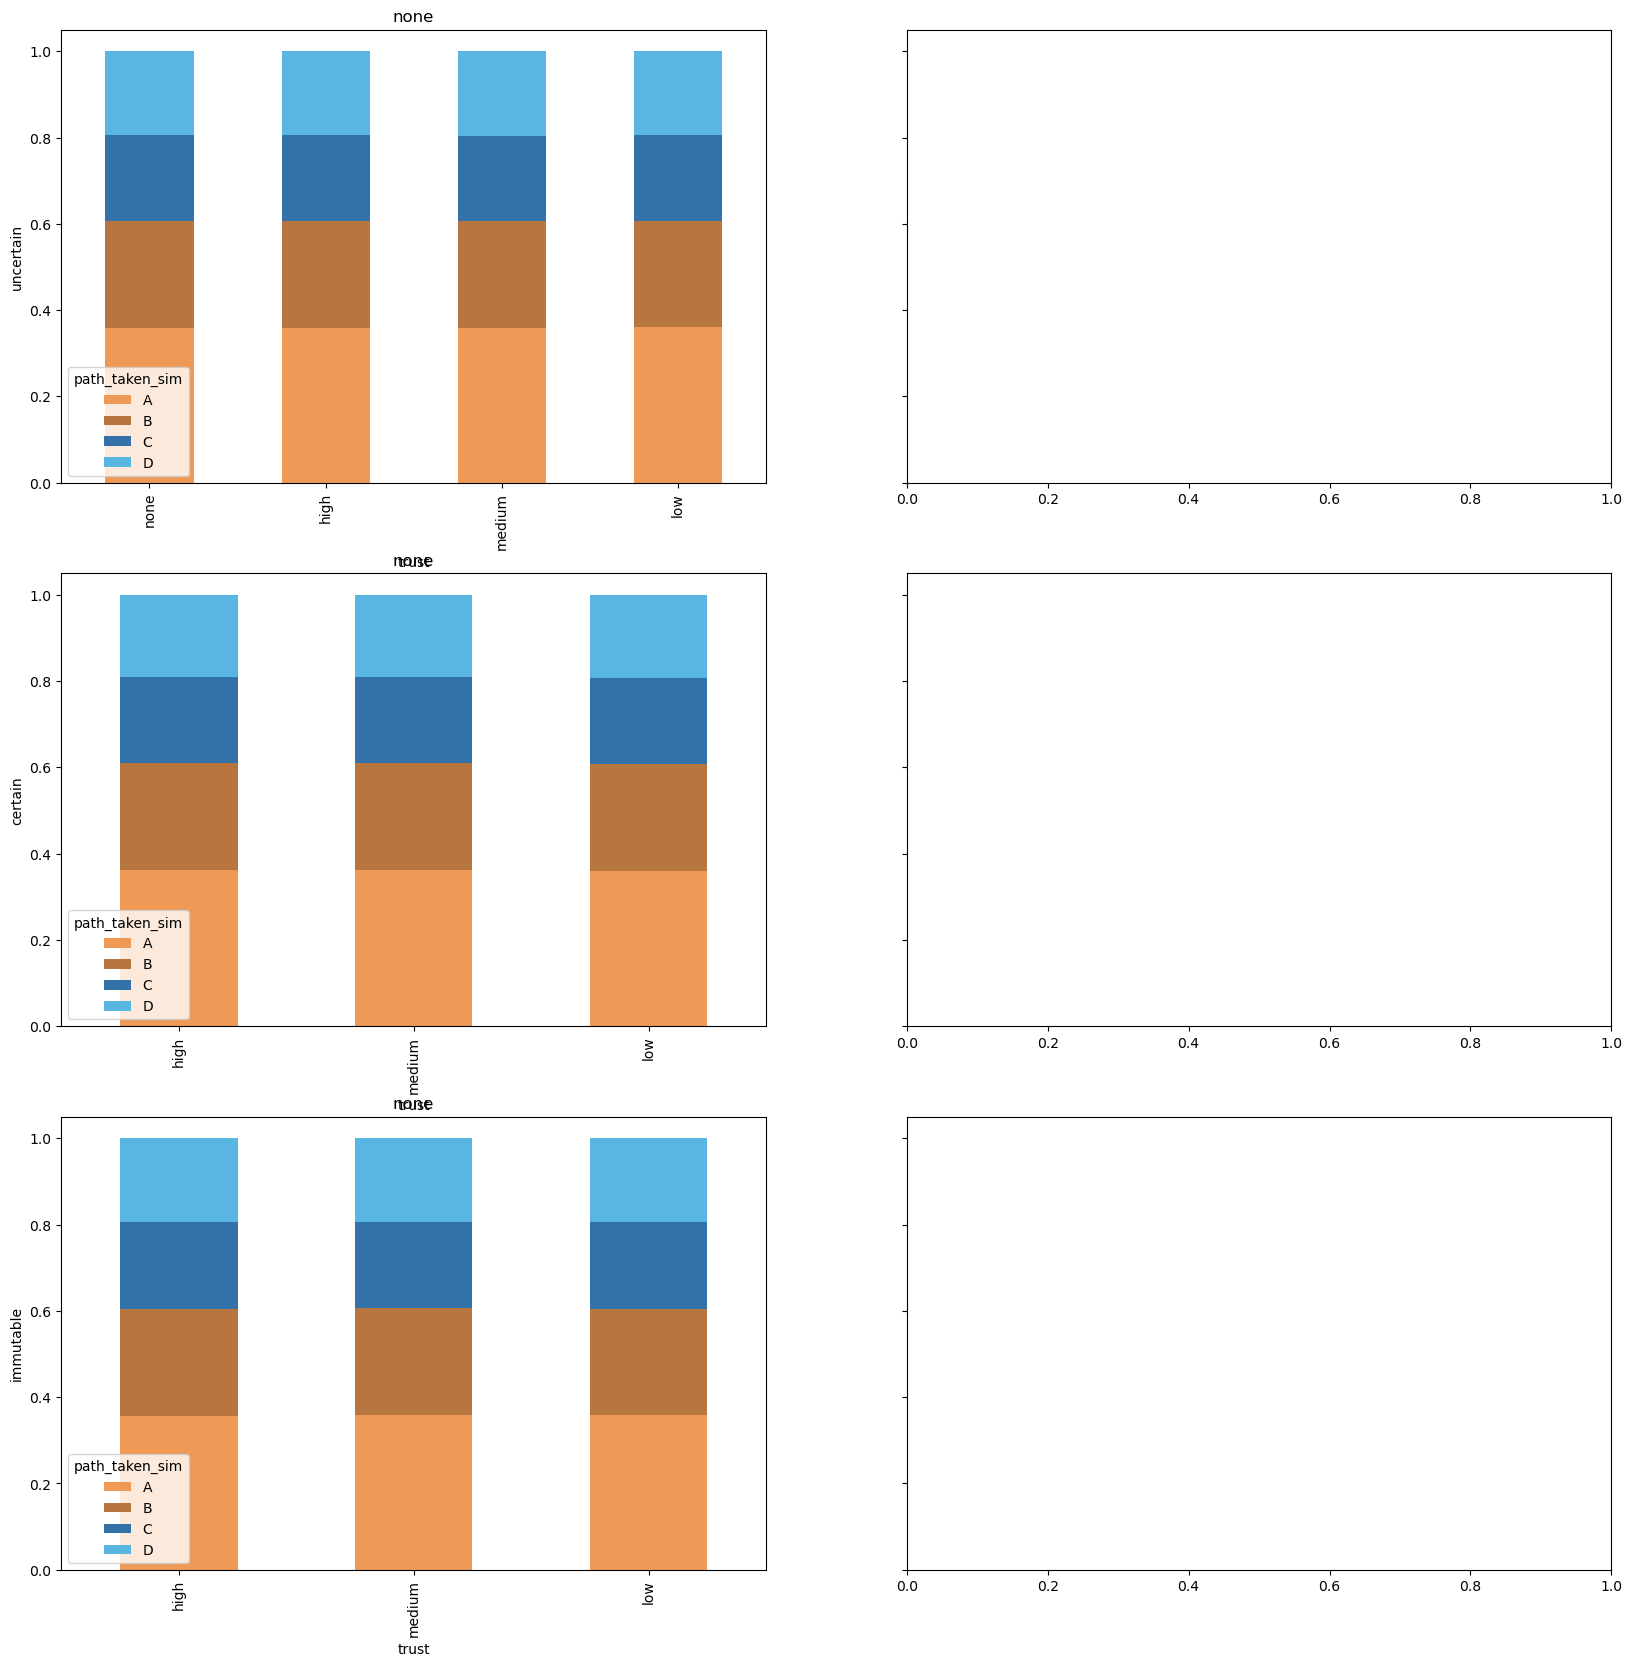

In [15]:
intentions = ['none', 'good']
interests = ['interested', 'disinterested']
#rigidities = np.sort(df.rigidity_val.dropna().unique())[::-1]
certainties = ['uncertain', 'certain', 'immutable']

trust_labels = [
    'none', 
    #'very_high', 
    'high', 
    #'slightly_high', 
    'medium', 
    #'slightly_low', 
    'low', 
    #'very_low'
]

fig, axes = plt.subplots(len(certainties), len(intentions), figsize=(20, 20), sharey=True)

for i, certainty in enumerate(certainties):
    for j, intention in enumerate(intentions):
        df_paths = df_Ys[(df_Ys.certainty == certainty)].groupby('trust').path_taken_sim.value_counts(normalize=True)
    
        
        if intention != 'none':
            continue
        # Reindex to only include trust_labels
        df_paths = df_paths.unstack().reindex(trust_labels).stack()
        # Set the order of trust labels to be as in trust_labels
        df_paths.unstack().plot(kind='bar', stacked=True, color=paths_colors, ax=axes[i, j])
        
        # Intention as y label only in the first column
        if j == 0:
            axes[i, j].set_ylabel(certainty)

        # Flexibility as title
        axes[i, j].set_title(intention)

## No beta

In [21]:
# Create list of participant data
part_data = []

# First drop all columns that are not y_sim
draws_y = draws.filter(like='y_nobeta_sim')
# Get the number of indices of M and N
M = stan_data['M']
N = stan_data['N']
# Iterate over the columns of draws_y

for col in draws_y.columns[:]:
    # Get the values of M and N from the column name
    mn = col.split('[')[1][:-1]
    m, n = mn.split(',')
    m = int(m)
    n = int(n)
    # Get the values of y_sim
    y_sim = draws_y[col].values

    
    # Create a new np array with the values of part_idx, block_idx and y_sim
    part_array = np.array([
        np.arange(y_sim.size),
        m*np.ones(y_sim.size), 
        n*np.ones(y_sim.size), 
        y_sim
    ]).T
    
    # Append to part_data
    part_data.append(part_array)

# Concatenate part_data
part_data_arr = np.concatenate(part_data)

In [47]:

# Add to draws_long
df_Ys = pd.DataFrame(part_data_arr.astype(int), columns=['sim_idx', 'part_idx', 'block_idx_local', 'y_sim'])

# Add certainty and trust to df_Ys_l
# Get the certainty and trust values for each block_idx
certainties = np.array(stan_data['certainties'])
trusts = np.array(stan_data['trusts'])

# Create new columns in df_Ys_l using the part_idx and block_idx columns as indices for certainties and trusts
df_Ys['certainty_lvl'] = certainties[df_Ys['part_idx'].values-1, df_Ys['block_idx_local'].values-1]
df_Ys['trust_lvl'] = trusts[df_Ys['part_idx'].values-1, df_Ys['block_idx_local'].values-1]

# Rename y_sim to path_idx_sim
df_Ys.columns = ['sim_idx', 'part_idx', 'block_idx_local', 'path_idx_sim', 'certainty_lvl', 'trust_lvl']

# Remap path_idx_sim to path_taken_sim using path_dict, same for certainty_lvl and trust_lvl
df_Ys['path_taken_sim'] = df_Ys['path_idx_sim'].map(lambda x: list(path_dict.keys())[list(path_dict.values()).index(x)])
df_Ys['certainty'] = df_Ys['certainty_lvl'].map(lambda x: list(certainties_dict.keys())[list(certainties_dict.values()).index(x)])
df_Ys['trust'] = df_Ys['trust_lvl'].map(lambda x: list(trust_dict.keys())[list(trust_dict.values()).index(x)])

df_Ys['part_idx'] = df_Ys['part_idx'] - 1
df_Ys['block_idx_local'] = df_Ys['block_idx_local'] - 1

# Recover participant code from pd.Categorical(df['participant_code']).codes
df_Ys['participant_code'] = pd.Categorical(df['participant_code']).categories[df_Ys['part_idx']-1]

df_Ys['block_idx'] = df_Ys['block_idx_local'] + 10

df_Ys = df_Ys[['sim_idx', 'part_idx', 'participant_code', 'block_idx_local', 'block_idx', 'certainty_lvl', 'trust_lvl', 'certainty', 'trust', 'path_idx_sim', 'path_taken_sim']]

# Save to csv
df_Ys.to_csv(f'stan_files/tom_model_{variant}_basic_y_nobeta_sim.csv', index=False)

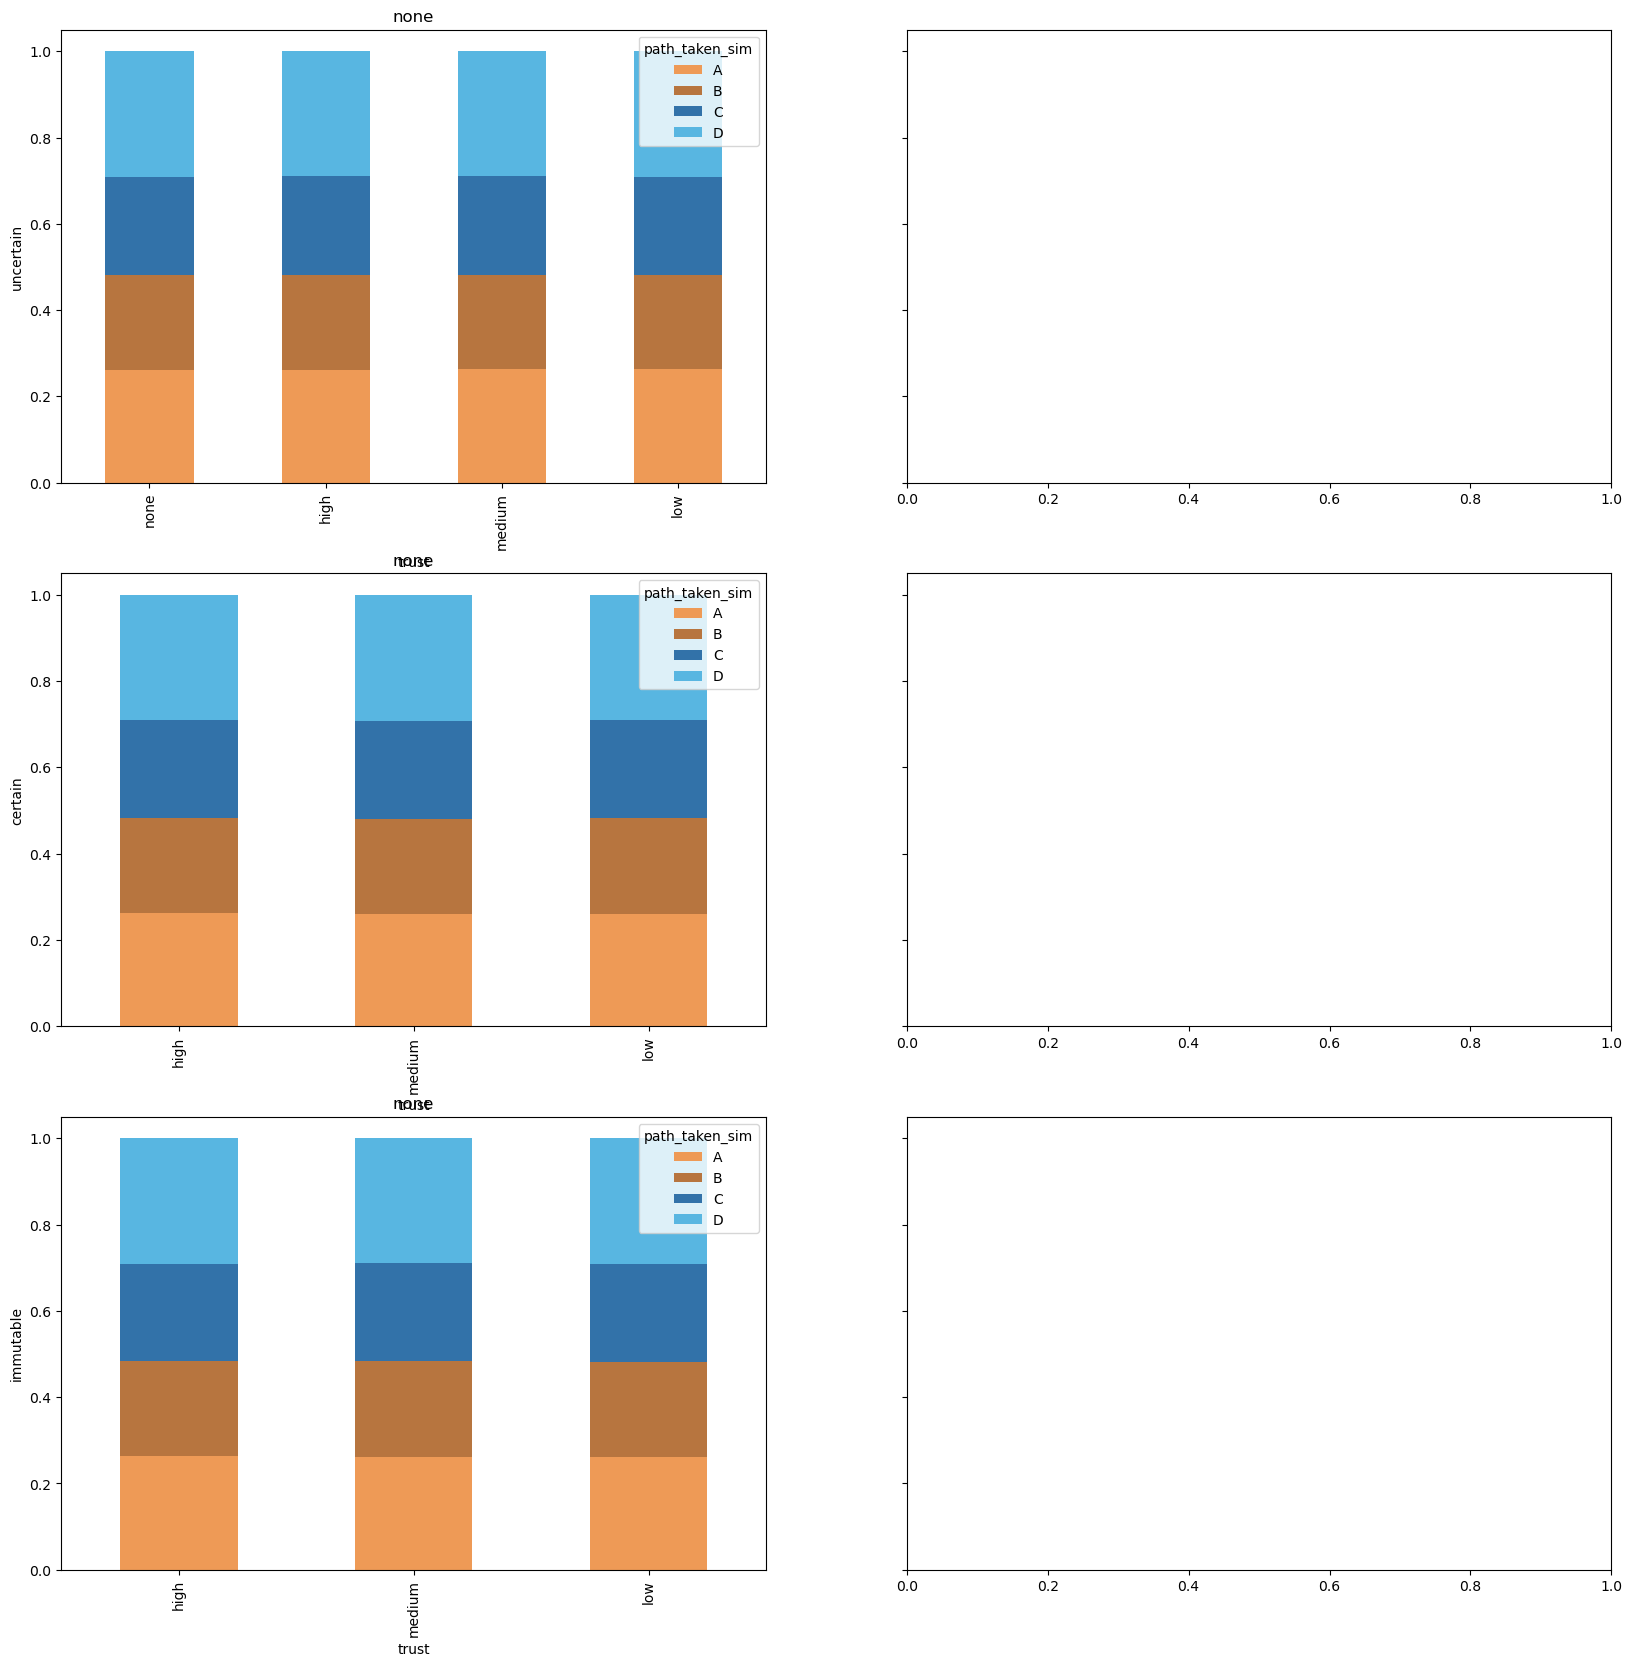

In [ ]:
intentions = ['none', 'good']
interests = ['interested', 'disinterested']
#rigidities = np.sort(df.rigidity_val.dropna().unique())[::-1]
certainties = ['uncertain', 'certain', 'immutable']

trust_labels = [
    'none', 
    #'very_high', 
    'high', 
    #'slightly_high', 
    'medium', 
    #'slightly_low', 
    'low', 
    #'very_low'
]

fig, axes = plt.subplots(len(certainties), len(intentions), figsize=(20, 20), sharey=True)

for i, certainty in enumerate(certainties):
    for j, intention in enumerate(intentions):
        df_paths = df_Ys[(df_Ys.certainty == certainty)].groupby('trust').path_taken_sim.value_counts(normalize=True)
    
        
        if intention != 'none':
            continue
        # Reindex to only include trust_labels
        df_paths = df_paths.unstack().reindex(trust_labels).stack()
        # Set the order of trust labels to be as in trust_labels
        df_paths.unstack().plot(kind='bar', stacked=True, color=paths_colors, ax=axes[i, j])
        
        # Intention as y label only in the first column
        if j == 0:
            axes[i, j].set_ylabel(certainty)

        # Flexibility as title
        axes[i, j].set_title(intention)